In [6]:
from surface_distribution import plot_surface_dist
from mmseg.datasets.pipelines import Compose
from mmcv import Config
from PIL import Image
import os

Processing WeiH:   0%|          | 0/5500 [00:00<?, ?it/s]

Processing WeiH: 100%|██████████| 5500/5500 [00:08<00:00, 651.08it/s]


for WeiH domain, 5% have less than 40.0 of surface and more than 5% have surface grater than 3845.7999999999884. min area = 1, max area = 13795


Processing I3: 100%|██████████| 11948/11948 [00:26<00:00, 454.75it/s]


for I3 domain, 5% have less than 109.70000000000005 of surface and more than 5% have surface grater than 17856.999999999985. min area = 1, max area = 39953


Processing LW4: 100%|██████████| 15953/15953 [00:35<00:00, 451.78it/s]


for LW4 domain, 5% have less than 119.0 of surface and more than 5% have surface grater than 9830.299999999996. min area = 1, max area = 20699


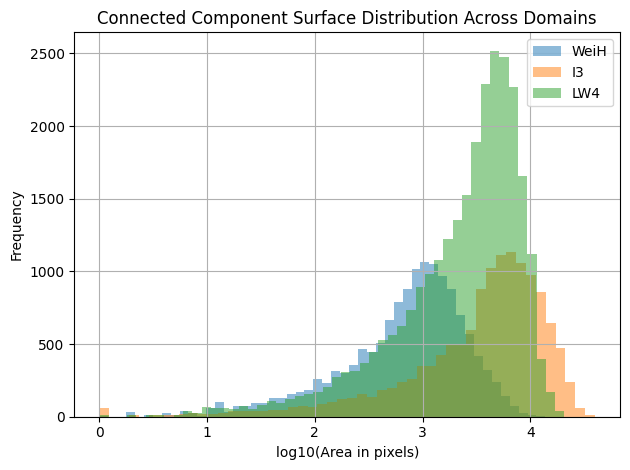

In [2]:
plot_surface_dist(["WeiH","I3","LW4"])

In [3]:
original_shape = 256*256
min_area = 10 ** 3
max_area = 10 ** 4

In [19]:
target_area = min_area

zoom_min = np.sqrt(target_area / max_area)

zoom_max = np.sqrt(target_area / min_area)

zoom_min,zoom_max

(0.31622776601683794, 1.0)

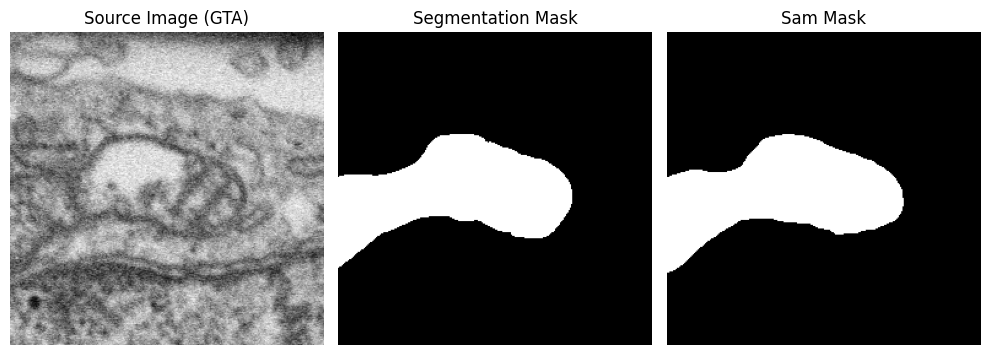

In [20]:
# Change this to match your actual path
img_path = 'data/I3/images/4.png'
mask_path = 'data/I3/labels/4.png'
sam_path = 'data/I3/sam/4.png'

# Load image and mask
image = Image.open(img_path).convert('RGB')
mask = Image.open(mask_path)
sam = Image.open(sam_path)

# Plot
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Source Image (GTA)")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(mask, cmap='jet')  
plt.title("Segmentation Mask")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(sam, cmap='jet')  
plt.title("Sam Mask")
plt.axis('off')

plt.tight_layout()
plt.show()


In [23]:
# Load your config file
cfg = Config.fromfile('configs/_base_/datasets/uda_I3_to_WeiH.py')

# Build pipeline
pipeline = Compose(cfg.data.train.source.pipeline)

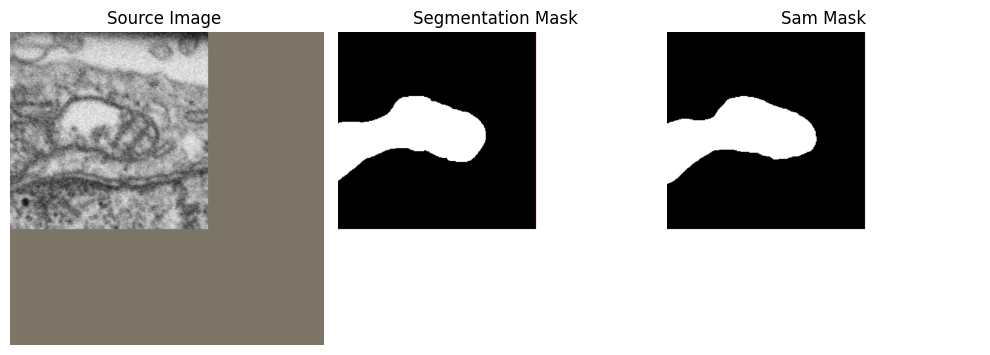

In [29]:
# Load a sample
data = dict(
    img_info=dict(filename='images/4.png'),
    ann_info=dict(seg_map='labels/4.png'),
    img_prefix='data/I3',
    seg_prefix='data/I3',
    pseudo_label_prefix='data/I3',  
    pseudo_label='sam/4.png',                              
    seg_fields=[],
    sam_fields=[]
)

# Apply pipeline
processed = pipeline(data)

# Visualize processed['img'] and processed['gt_semantic_seg']
import torch
import numpy as np

img = processed['img'].data.numpy().transpose(1, 2, 0)  # [C, H, W] -> [H, W, C]
img = (img * cfg.img_norm_cfg['std']) + cfg.img_norm_cfg['mean']  # denormalize
img = img.astype(np.uint8)

mask = processed['gt_semantic_seg'].data.squeeze().numpy()

sam = processed["sam_pseudo_label"].data.squeeze().numpy()

# Plot
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title("Source Image ")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(mask, cmap='jet')  
plt.title("Segmentation Mask")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(sam, cmap='jet')  
plt.title("Sam Mask")
plt.axis('off')

plt.tight_layout()
plt.show()
